
# Langgraph with AgentNeo Integration
 This Jupyter notebook demonstrates the integration of AgentNeo, a powerful tracing and monitoring tool, with Langgraph, a graph-based approach to managing language models with an agent-based system to enhance the automation and decision-making capabilities of your application. This integration allows for comprehensive analysis and debugging of AI-powered systems.


 # Setup and Imports
First, let's import the necessary libraries and set up our environment.

In [1]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [2]:
import getpass
import os
import openai
from litellm import completion
from typing import List, Dict, Any
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel

# Function for the OpenAI API key if it's not already set in the environment
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")


 # Initialize AgentNeo Session and Tracer
 Now, let's set up our AgentNeo session and tracer.



In [4]:
import os
os.chdir('..')

# Import AgentNeo and Setup Tracing
from agentneo import AgentNeo, Tracer, Evaluation, launch_dashboard 

# Initialize AgentNeo session
neo_session = AgentNeo(session_name="langGraph_example1")
try:
    neo_session.create_project(project_name="LangGraph_with_AgentNeo3 ")
except:
    neo_session.connect_project(project_name="LangGraph_with_AgentNeo3")

# Create tracer
tracer = Tracer(session=neo_session)

tracer.start()

Project 'LangGraph_with_AgentNeo3 ' found.
Tracing Started.



 # Define Agents and Tools
Now, let's create our AI tools using langgraph.

In [5]:
# Create a standalone PromptInstructions class
@tracer.trace_agent(name="PromptInstructions")
class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]



In [6]:
# Create a class for managing prompt generation
@tracer.trace_agent(name="PromptGenerator")
class PromptGenerator:
    def __init__(self):
        self.template = """Your job is to get information from a user about what type of prompt template they want to create.

        You should get the following information from them:

        - What the objective of the prompt is
        - What variables will be passed into the prompt template
        - Any constraints for what the output should NOT do
        - Any requirements that the output MUST adhere to

        If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

        After you are able to discern all the information, call the relevant tool."""
        
        self.llm = ChatOpenAI(temperature=0.5)
        self.llm_with_tool = self.llm.bind_tools([PromptInstructions])

    @tracer.trace_tool(name="get message")
    def get_messages_info(self, messages):
        return [SystemMessage(content=self.template)] + messages

    @tracer.trace_tool(name="info chain")
    def info_chain(self, state):
        messages = self.get_messages_info(state["messages"])
        response = self.llm_with_tool.invoke(messages)
        return {"messages": [response]}

    @tracer.trace_tool(name="get prompt")
    def get_prompt_messages(self, messages: list):
        tool_call = None
        other_msgs = []
        for m in messages:
            if isinstance(m, AIMessage) and m.tool_calls:
                tool_call = m.tool_calls[0]["args"]
            elif isinstance(m, ToolMessage):
                continue
            elif tool_call is not None:
                other_msgs.append(m)
        prompt_system = """Based on the following requirements, write a good prompt template:
        
        {reqs}"""
        return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs

    @tracer.trace_tool(name="prompt gen chain")
    def prompt_gen_chain(self, state):
        messages = self.get_prompt_messages(state["messages"])
        response = self.llm.invoke(messages)
        return {"messages": [response]}

In [7]:
# Instantiate the PromptGenerator class
prompt_generator = PromptGenerator()

In [8]:
# Importing the `Literal` type from the `typing` module, which allows defining specific literal values for type hints.

from typing import Literal
# Importing END which likely represents the end or termination of a process or a node
from langgraph.graph import END

@tracer.trace_tool(name="get state")
def get_state(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"


# # Importing necessary components 
managing state graphs, saving memory, handling messages, and typing annotations.

In [9]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

@tracer.trace_agent(name="workflow")
class State(TypedDict):
    messages: Annotated[list, add_messages]

memory = MemorySaver()
workflow = StateGraph(State)

# Instantiate the PromptGenerator class
prompt_generator = PromptGenerator()

workflow.add_node("info", prompt_generator.info_chain)
workflow.add_node("prompt", prompt_generator.prompt_gen_chain)

@workflow.add_node
def add_tool_message(state: State):
    return {
        "messages": [
            ToolMessage(
                content="Prompt generated!",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }

workflow.add_conditional_edges("info", get_state, ["add_tool_message", "info", END])
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")
graph = workflow.compile(checkpointer=memory)

DEBUG:agentneo.tracing.agent_tracer:Successfully updated and committed AgentCallModel with id 20



# Displaying a PNG image of a graph generated from a LangGraph instance using Mermaid visualization

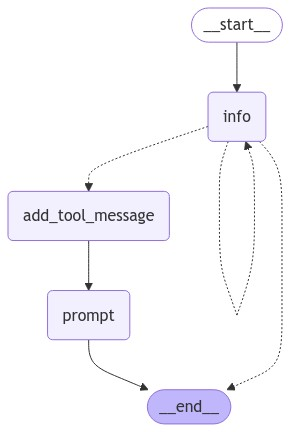

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


 # Continuously prompts the user for input
  streams responses from the graph, and handles fallback cached responses in case of input failure.

In [11]:

from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

import uuid

cached_human_responses = ["hi!", "rag prompt", "1 rag, 2 none, 3 no, 4 no", "red", "q"]
cached_response_index = 0
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

while True:
    try:
        user = input("User (q/Q to quit): ")
    except:
        user = cached_human_responses[cached_response_index]
        cached_response_index += 1
    print(f"User (q/Q to quit): {user}")
    
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
        
    output = None
    for output in graph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")



User (q/Q to quit): 


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Can you please provide more details on what type of prompt template you would like to create? Specifically, I would need to know the following information:

- What is the objective of the prompt?
- What variables will be passed into the prompt template?
- Any constraints for what the output should NOT do?
- Any requirements that the output MUST adhere to?

Once I have this information, I can assist you in creating the prompt template.
User (q/Q to quit): 


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

I'm sorry, but I need more information in order to assist you. Could you please provide details on the following:

1. What is the objective of the prompt template you want to create?
2. What variables will be passed into the prompt template?
3. Are there any constraints for what the output should NOT do?
4. Are there any specific requirements that the output MUST adhere to?

Once I have this information, I can help you create the prompt template.
User (q/Q to quit): q
AI: Byebye


In [12]:
# Stop Tracing and Launch Dashboard
tracer.stop()
print(tracer.trace_id)

Tracing Completed.
Data saved to the database and JSON file.

14



 # Metrics Evaluation
 Supported Metrics Goal Decomposition Efficiency (goal_decomposition_efficiency) Goal Fulfillment Rate (goal_fulfillment_rate) Tool Correctness Metric (tool_correctness_metric) Tool Call Success Rate Metric (tool_call_success_rate_metric)


In [14]:
# Execute metrics
from agentneo import Evaluation
exe = Evaluation(session=neo_session, trace_id=tracer.trace_id)  
exe.evaluate(metric_list=['goal_decomposition_efficiency', 'goal_fulfillment_rate', 'tool_call_success_rate_metric'])
metric_results = exe.get_results()
print(metric_results) 
metric_results

13:17:55 - LiteLLM:INFO: utils.py:2740 - 
LiteLLM completion() model= gpt-4o-mini; provider = openai
INFO:LiteLLM:
LiteLLM completion() model= gpt-4o-mini; provider = openai
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
13:17:57 - LiteLLM:INFO: utils.py:938 - Wrapper: Completed Call, calling success_handler
INFO:LiteLLM:Wrapper: Completed Call, calling success_handler
13:17:57 - LiteLLM:INFO: utils.py:2740 - 
LiteLLM completion() model= gpt-4o-mini; provider = openai
INFO:LiteLLM:
LiteLLM completion() model= gpt-4o-mini; provider = openai
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
13:17:58 - LiteLLM:INFO: utils.py:938 - Wrapper: Completed Call, calling success_handler
INFO:LiteLLM:Wrapper: Completed Call, calling success_handler
13:17:58 - LiteLLM:INFO: utils.py:2740 - 
LiteLLM completion() model= gpt-4o-mini; provider = openai
INFO:LiteLLM:
LiteLLM completion() model= gpt-4o-mini; provider = o

[{'metric_name': 'goal_decomposition_efficiency', 'score': 0.85, 'reason': "The AI effectively decomposed the original goal into clear and relevant sub-tasks that cover all necessary aspects of creating a prompt template. Each sub-task is logically sequenced and independent, allowing for efficient execution. However, while the decomposition is comprehensive, there could be slight improvements in granularity, such as breaking down the final sub-task into more specific actions (e.g., drafting the template based on the gathered information). Overall, the decomposition is efficient and aligns well with the user's needs.", 'result_detail': {'metric_name': 'goal_fulfillment_rate', 'config': {}, 'result': {'originalGoal': 'Assist the user in creating a prompt template by providing specific guidance on structure, objectives, variables, constraints, and requirements.', 'subtasks': ['Ask the user for details on the objective of the prompt template.', 'Inquire about the variables that will be pas

[{'metric_name': 'goal_decomposition_efficiency',
  'score': 0.85,
  'reason': "The AI effectively decomposed the original goal into clear and relevant sub-tasks that cover all necessary aspects of creating a prompt template. Each sub-task is logically sequenced and independent, allowing for efficient execution. However, while the decomposition is comprehensive, there could be slight improvements in granularity, such as breaking down the final sub-task into more specific actions (e.g., drafting the template based on the gathered information). Overall, the decomposition is efficient and aligns well with the user's needs.",
  'result_detail': {'metric_name': 'goal_fulfillment_rate',
   'config': {},
   'result': {'originalGoal': 'Assist the user in creating a prompt template by providing specific guidance on structure, objectives, variables, constraints, and requirements.',
    'subtasks': ['Ask the user for details on the objective of the prompt template.',
     'Inquire about the varia

In [15]:
# Launching dashboard
neo_session.launch_dashboard()


INFO:root:Dashboard launched successfully. Access it at: http://localhost:3000
